In [572]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [573]:
# Silencing warnings (not best practice, but its to prevent future spam)
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
import celltypist
from celltypist import models

### Cleaning and Opening Reference Data

In [ ]:
# Untarring the reference data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116256
!tar -xvf ref_data/GSE116256_RAW.tar

In [ ]:
# Double check that all is well
!ls ref_data

In [4]:
rdatas = []

# Iterate over all files for all dem files
for dem in [x for x in os.listdir('ref_data/') if 'dem' in x]:  
    basename = dem.split('.')[0]  # Extract the basename
    samp = basename.split('_')[1]  # Extract the sample identifier

    # Find the corresponding annotation file that has the same sample identifier
    anno = [x for x in os.listdir('ref_data/') 
            if samp == x.split('_')[1].split('.')[0] and 'anno' in x][0]

    # Read the expression data (transpose needed for correct orientation)
    temp_data = sc.read_text('ref_data/' + dem).T  

    # Getting CellType column only 
    temp_anno = pd.read_table('ref_data/' + anno, index_col=0)[['CellType']]  

    temp_data.obs = temp_data.obs.merge(right=temp_anno, left_index=True, right_index=True)  

    # Add an 'ID' column to store the dataset identifier
    temp_data.obs['ID'] = basename  

    # Append the processed data to the list
    rdatas.append(temp_data)

In [5]:
# Concatenating to Ann Data Object, deleting base list to save memory as we go
rdata = sc.concat(rdatas)
del rdatas

In [6]:
# Looks all good!
rdata

AnnData object with n_obs × n_vars = 41090 × 27899
    obs: 'CellType', 'ID'

In [7]:
rdata.obs.groupby('CellType').size()

CellType
B                520
CTL             1338
GMP              918
GMP-like        3055
HSC             1709
HSC-like        1979
Mono            2758
Mono-like       2655
NK              1969
Plasma          1146
ProB             298
ProMono         1146
ProMono-like    1917
Prog            1709
Prog-like       4438
T               7105
cDC              849
cDC-like        2125
earlyEry        1119
lateEry         1329
pDC              225
dtype: int64

### Forming CellTypist Reference Model #1

In [8]:
# Based on CellTypist reccomendations, we will normalize our data to 10000 since we are using celltypist but want to acknowledge this isnt typical
sc.pp.filter_genes(rdata, min_cells = 10)
sc.pp.normalize_total(rdata, target_sum = 1e4)
sc.pp.log1p(rdata)

In [9]:
# All is well!
rdata.obs

CellType                     ID
AML1012-D0_AAAAAGTTACGT           GMP  GSM3587923_AML1012-D0
AML1012-D0_AAAACACCAATC      GMP-like  GSM3587923_AML1012-D0
AML1012-D0_AAAATAGCCTTT     Prog-like  GSM3587923_AML1012-D0
AML1012-D0_AAACATTAAACG  ProMono-like  GSM3587923_AML1012-D0
AML1012-D0_AAACCACGTGCN     Prog-like  GSM3587923_AML1012-D0
...                               ...                    ...
OCI-AML3_TTTGAGCCAACC        GMP-like    GSM3588005_OCI-AML3
OCI-AML3_TTTGCCACAGGC    ProMono-like    GSM3588005_OCI-AML3
OCI-AML3_TTTTATGAATTN        GMP-like    GSM3588005_OCI-AML3
OCI-AML3_TTTTGACTTTTN        GMP-like    GSM3588005_OCI-AML3
OCI-AML3_TTTTGTGACCGT        GMP-like    GSM3588005_OCI-AML3

[41090 rows x 2 columns]

In [10]:
# Removing Na CellType vals 
rdata = rdata[~rdata.obs.CellType.isna()]

In [11]:
rdata

View of AnnData object with n_obs × n_vars = 40307 × 19616
    obs: 'CellType', 'ID'
    var: 'n_cells'
    uns: 'log1p'

In [12]:
ref_model = celltypist.train(rdata, labels = 'CellType', n_jobs = 4,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

🍳 Preparing data before training
🔬 Input data has 40307 cells and 19616 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2497 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [ ]:
# Saving model for future ref. 
!mkdir models

In [16]:
ref_model.write('/mnt/c/Users/micha/Documents/SC25/models/ref.pkl')

### Forming CellTypist Reference Model #2

In [3]:
# For converting AnnData and SingleCellExperiment, running R code
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

cffi mode is CFFI_MODE.ANY
R home found: /usr/lib/R
R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
Default options to initialize R: rpy2, --quiet, --no-save
R is already initialized. No need to initialize.
/tmp/ipykernel_681/1488781608.py:3: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
%%R
library(Seurat)
library(SummarizedExperiment)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSu

Reading range summarized experiment as a seurat object with counts and metadata, then transforming to SingleCellExeperiment Obj

In [5]:
%%R -o healthy

rse <- readRDS("ref_data2/scRNA-Healthy-Hematopoiesis-191120.rds")

seurat_object <- CreateSeuratObject(counts = assay(rse, "counts"), meta.data = as.data.frame(colData(rse)))

healthy <- as.SingleCellExperiment(seurat_object)

In addition: Warning messages:
1: Layer ‘data’ is empty 
2: Layer ‘scale.data’ is empty 


In [6]:
# looks good : )
healthy.obs

orig.ident  nCount_RNA  \
CD34_32_R5:AAACCTGAGTATCGAA-1                    CD34      8303.0   
CD34_32_R5:AAACCTGAGTCGTTTG-1                    CD34      3917.0   
CD34_32_R5:AAACCTGGTTCCACAA-1                    CD34      6023.0   
CD34_32_R5:AAACGGGAGCTTCGCG-1                    CD34      4493.0   
CD34_32_R5:AAACGGGAGGGAGTAA-1                    CD34      5190.0   
...                                               ...         ...   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1       BMMC      5240.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1       BMMC      1338.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1       BMMC      1660.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATGTGTCA-1       BMMC      1631.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATTGAAAG-1       BMMC      1665.0   

                                            nFeature_RNA      Group  nUMI_pre  \
CD34_32_R5:AAACCTGAGTATCGAA-1                       3187  CD34_D2T1   17876.0   
CD34_32_R5:AAACCTGAGTCGTTTG-1                       1787  CD34_D2T1    9277.0   
CD34_32_R5:AAACCTGGTTCCACAA-1                       2552  CD34_D2T1   13073.0   
CD34_32_R5:AAACGGGAGCTTCGCG-1                       2191  CD34_D2T1    8412.0   
CD34_32_R5:AAACGGGAGGGAGTAA-1                       2322  CD34_D2T1   11914.0   
...                                                  ...        ...       ...   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1          2377  BMMC_D1T2    7515.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1           882  BMMC_D1T2    1597.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1          1004  BMMC_D1T2    2831.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATGTGTCA-1           951  BMMC_D1T2    2852.0   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATTGAAAG-1           963  BMMC_D1T2    2759.0   

                                              nUMI   nGene initialClusters  \
CD34_32_R5:AAACCTGAGTATCGAA-1               8303.0  3187.0        Cluster1   
CD34_32_R5:AAACCTGAGTCGTTTG-1               3917.0  1787.0        Cluster2   
CD34_32_R5:AAACCTGGTTCCACAA-1               6023.0  2552.0        Cluster3   
CD34_32_R5:AAACGGGAGCTTCGCG-1               4493.0  2191.0        Cluster4   
CD34_32_R5:AAACGGGAGGGAGTAA-1               5190.0  2322.0        Cluster3   
...                                            ...     ...             ...   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1  5240.0  2377.0        Cluster9   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1  1338.0   882.0       Cluster16   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1  1660.0  1004.0       Cluster22   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATGTGTCA-1  1631.0   951.0       Cluster26   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATTGAAAG-1  1665.0   963.0       Cluster12   

                                               UMAP1      UMAP2   Clusters  \
CD34_32_R5:AAACCTGAGTATCGAA-1              -6.113410   4.616498   Cluster5   
CD34_32_R5:AAACCTGAGTCGTTTG-1              -8.800932  -1.228907   Cluster8   
CD34_32_R5:AAACCTGGTTCCACAA-1              -9.723482   7.335178   Cluster1   
CD34_32_R5:AAACGGGAGCTTCGCG-1              -4.293071   5.692705   Cluster6   
CD34_32_R5:AAACGGGAGGGAGTAA-1              -7.989706   9.108693   Cluster1   
...                                              ...        ...        ...   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1 -5.708933  -2.843953   Cluster7   
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1 -2.258849 -10.712415  Cluster12   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1  4.987181  -8.794110  Cluster19   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATGTGTCA-1  6.086861  -3.454188  Cluster20   
BMMC_10x_GREENLEAF_REP2:TTTGTTGCATTGAAAG-1  1.101248  12.074113  Cluster17   

                                           BioClassification  \
CD34_32_R5:AAACCTGAGTATCGAA-1                    05_CMP.LMPP   
CD34_32_R5:AAACCTGAGTCGTTTG-1                    08_GMP.Neut   
CD34_32_R5:AAACCTGGTTCCACAA-1                         01_HSC   
CD34_32_R5:AAACGGGAGCTTCGCG-1                       06_CLP.1   
CD34_32_R5:AAACGGGAGGGAGTAA-1                  

In [9]:
sc.pp.normalize_total(healthy, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
sc.pp.log1p(healthy)

In [10]:
ref2_model = celltypist.train(healthy, labels = 'BioClassification', n_jobs = 1,
                            use_SGD = False,
                            feature_selection = True, top_genes = 300)

🍳 Preparing data before training
✂️ 3368 non-expressed genes are filtered out
🔬 Input data has 35582 cells and 16919 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2850 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [11]:
ref2_model.write('/mnt/c/Users/micha/Documents/SC25/models/ref2.pkl')

#### Loading the 3 Models

In [33]:
ref_model = models.Model.load(model="models/ref.pkl")
ref2_model = models.Model.load(model="models/ref2.pkl")
model_low = models.Model.load(model="Immune_All_Low.pkl")

In [13]:
def predict_cells(adata):
    
    # Filter out genes that are expressed in fewer than 10 cells (this reduces noise).
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Normalize the total counts per cell to a fixed target sum (1e4). 
    # This is often not recommended for typical preprocessing
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Convert sparse matrix (if any) to dense format. 
    adata.X = adata.X.toarray()
    predictions = celltypist.annotate(adata, model=model_low, majority_voting=False)
    
    # Convert the predictions to an AnnData object to store them in a structured format.
    predictions_adata = predictions.to_adata()
    
    # Add the predicted labels and confidence scores from the "low" model into the observation metadata (obs) of adata.
    adata.obs["low_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["low_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    # Repeat the same process for the "reference" model.
    predictions = celltypist.annotate(adata, model=ref_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["ref_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["ref_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]
    predictions = celltypist.annotate(adata, model=ref2_model, majority_voting=False)
    predictions_adata = predictions.to_adata()
    adata.obs["ref2_label"] = predictions_adata.obs.loc[adata.obs.index, "predicted_labels"]
    adata.obs["ref2_score"] = predictions_adata.obs.loc[adata.obs.index, "conf_score"]

    # Return the observation metadata containing all the predictions and their confidence scores.
    return adata.obs

In [16]:
!pwd

/mnt/c/Users/micha/Documents/SC25


In [20]:
# Opening .h5 files from preprocessing
adatas = [sc.read_h5ad('processed_batches/' + x) for x in os.listdir('processed_batches')]

In [21]:
# Sanity Check
len(adatas)

75

In [22]:
# Makes a .copy to prevent normalization, runs celltypist predictions
predictions = [predict_cells(ad.copy()) for ad in adatas]

🔬 Input data has 5868 cells and 15670 genes
🔗 Matching reference genes in the model
🧬 4844 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 5868 cells and 15670 genes
🔗 Matching reference genes in the model
🧬 2276 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 5868 cells and 15670 genes
🔗 Matching reference genes in the model
🧬 2683 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 4884 cells and 13893 genes
🔗 Matching reference genes in the model
🧬 4356 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 4884 cells and 13893 genes
🔗 Matching reference genes in the model
🧬 2152 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 4884 cells and 13893 genes
🔗 Matching reference genes in the model
🧬 2487

In [23]:
# Making pd df with predictions and pulling essential lables only
predictions = pd.concat(predictions)[['low_label', 'low_score', 'ref_label', 'ref_score', 'ref2_label', 'ref2_score']]

predictions

low_label  low_score  \
TCAAGACCATCGCTGG-1-AML16_DX  Neutrophil-myeloid progenitor   0.787524   
TCTACATGTCCGGCAT-1-AML16_DX            Classical monocytes   0.157189   
TCGTCCATCGAACCTA-1-AML16_DX  Neutrophil-myeloid progenitor   0.944807   
TACCGGGGTTTACGAC-1-AML16_DX                  Mid erythroid   0.999895   
GATGACTTCTCGGTAA-1-AML16_DX  Neutrophil-myeloid progenitor   0.318441   
...                                                    ...        ...   
GCATGATAGACGGTTG-1-AML2_REM            Classical monocytes   0.589415   
GTTACAGTCCGGTAGC-1-AML2_REM            Classical monocytes   0.937319   
CATTGCCCATGACTCA-1-AML2_REM            Classical monocytes   0.061891   
AGACAGGAGTCAGCGA-1-AML2_REM            Classical monocytes   0.966262   
CATACTTGTATGCTAC-1-AML2_REM            Classical monocytes   0.622659   

                             ref_label  ref_score      ref2_label  ref2_score  
TCAAGACCATCGCTGG-1-AML16_DX   GMP-like   0.999999     08_GMP.Neut    0.999397  
TCTACATGTCCGGCAT-1-AML16_DX    lateEry   0.000144   03_Late.Eryth    0.993653  
TCGTCCATCGAACCTA-1-AML16_DX   GMP-like   1.000000     08_GMP.Neut    0.999847  
TACCGGGGTTTACGAC-1-AML16_DX    lateEry   1.000000   03_Late.Eryth    1.000000  
GATGACTTCTCGGTAA-1-AML16_DX   GMP-like   0.999998     08_GMP.Neut    0.978792  
...                                ...        ...             ...         ...  
GCATGATAGACGGTTG-1-AML2_REM  Mono-like   1.000000  02_Early.Eryth    0.005448  
GTTACAGTCCGGTAGC-1-AML2_REM   HSC-like   0.962999  12_CD14.Mono.2    0.998319  
CATTGCCCATGACTCA-1-AML2_REM   GMP-like   0.999987   03_Late.Eryth    0.042873  
AGACAGGAGTCAGCGA-1-AML2_REM   HSC-like   0.821266  12_CD14.Mono.2    1.000000  
CATACTTGTATGCTAC-1-AML2_REM   GMP-like   0.891541  12_CD14.Mono.2    0.607221  

[300690 rows x 6 columns]

In [24]:
# Making one adata .obj
adata = sc.concat(adatas)

In [25]:
# Saving predictions as a .csv
predictions.to_csv('PREDICTIONS.csv')

#### Making unintigrated dataset with our predictions

In [35]:
predictions = pd.read_csv('PREDICTIONS.csv')

In [51]:
adata = sc.read('merged_data.h5')

In [58]:
adata.obs = adata.obs.join(predictions, how="left")

In [59]:
print(predictions.head())

                                                 low_label  low_score  \
Unnamed: 0                                                              
TCAAGACCATCGCTGG-1-AML16_DX  Neutrophil-myeloid progenitor   0.787524   
TCTACATGTCCGGCAT-1-AML16_DX            Classical monocytes   0.157189   
TCGTCCATCGAACCTA-1-AML16_DX  Neutrophil-myeloid progenitor   0.944807   
TACCGGGGTTTACGAC-1-AML16_DX                  Mid erythroid   0.999895   
GATGACTTCTCGGTAA-1-AML16_DX  Neutrophil-myeloid progenitor   0.318441   

                            ref_label  ref_score     ref2_label  ref2_score  
Unnamed: 0                                                                   
TCAAGACCATCGCTGG-1-AML16_DX  GMP-like   0.999999    08_GMP.Neut    0.999397  
TCTACATGTCCGGCAT-1-AML16_DX   lateEry   0.000144  03_Late.Eryth    0.993653  
TCGTCCATCGAACCTA-1-AML16_DX  GMP-like   1.000000    08_GMP.Neut    0.999847  
TACCGGGGTTTACGAC-1-AML16_DX   lateEry   1.000000  03_Late.Eryth    1.000000  
GATGACTTCTCGGTAA-1-A

In [60]:
print(adata.obs.head())

                            Patient  DX    Sample  n_genes  n_genes_by_counts  \
TCAAGACCATCGCTGG-1-AML16_DX   AML16  DX  AML16_DX     6710               6710   
TCTACATGTCCGGCAT-1-AML16_DX   AML16  DX  AML16_DX     6996               6996   
TCGTCCATCGAACCTA-1-AML16_DX   AML16  DX  AML16_DX     6587               6587   
TACCGGGGTTTACGAC-1-AML16_DX   AML16  DX  AML16_DX     6424               6424   
GATGACTTCTCGGTAA-1-AML16_DX   AML16  DX  AML16_DX     6337               6337   

                             log1p_n_genes_by_counts  total_counts  \
TCAAGACCATCGCTGG-1-AML16_DX                 8.811503       54567.0   
TCTACATGTCCGGCAT-1-AML16_DX                 8.853237       53716.0   
TCGTCCATCGAACCTA-1-AML16_DX                 8.793005       50418.0   
TACCGGGGTTTACGAC-1-AML16_DX                 8.767952       49252.0   
GATGACTTCTCGGTAA-1-AML16_DX                 8.754319       47161.0   

                             log1p_total_counts  pct_counts_in_top_20_genes  \
TCAAGACCATCGC

In [61]:
# Saving prediction data
adata.write("unintegrated_predicted_data.h5ad")

... storing 'low_label' as categorical
... storing 'ref_label' as categorical
... storing 'ref2_label' as categorical


#### Integration

In [2]:
import scvi
from scvi.autotune import ModelTuner
from ray import tune
import scanpy as sc

In [3]:
adata = sc.read("unintegrated_predicted_data.h5ad")

In [4]:
sc.pp.filter_genes(adata, min_cells = 50)

In [5]:
adata

AnnData object with n_obs × n_vars = 300690 × 21163
    obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet', 'doublet_score', 'low_label', 'low_score', 'ref_label', 'ref_score', 'ref2_label', 'ref2_score'
    var: 'n_cells'

In [6]:
# Setting up SCVI model and AnnData object
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, categorical_covariate_keys = ['Sample'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

tuner = ModelTuner(model_cls)

In [7]:
tuner.info()

ModelTuner registry for SCVI

                  Tunable hyperparameters                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃      Hyperparameter      ┃ Default value ┃    Source    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│         n_hidden         │      128      │     VAE      │
│         n_latent         │      10       │     VAE      │
│         n_layers         │       1       │     VAE      │
│       dropout_rate       │      0.1      │     VAE      │
│        dispersion        │     gene      │     VAE      │
│     log_variational      │     True      │     VAE      │
│     gene_likelihood      │     zinb      │     VAE      │
│   latent_distribution    │    normal     │     VAE      │
│    encode_covariates     │     False     │     VAE      │
│ deeply_inject_covariates │     True      │     VAE      │
│      use_batch_norm      │     both      │     VAE      │
│      use_layer_norm      │     none      │     VAE      │
│  use_observed_lib_size   │     True      │     VAE      │
│      var_activation      │     None      │     VAE      │
│        optimizer         │     Adam      │ TrainingPlan │
│            lr            │     0.001     │ TrainingPlan │
│       weight_decay       │     1e-06     │ TrainingPlan │
│           eps            │     0.01      │ TrainingPlan │
│    n_steps_kl_warmup     │     None      │ TrainingPlan │
│    n_epochs_kl_warmup    │      400      │ TrainingPlan │
│   reduce_lr_on_plateau   │     False     │ TrainingPlan │
│        lr_factor         │      0.6      │ TrainingPlan │
│       lr_patience        │      30       │ TrainingPlan │
│       lr_threshold       │      0.0      │ TrainingPlan │
│          lr_min          │       0       │ TrainingPlan │
│      max_kl_weight       │      1.0      │ TrainingPlan │
│      min_kl_weight       │      0.0      │ TrainingPlan │
│        batch_size        │      128      │     SCVI     │
└──────────────────────────┴───────────────┴──────────────┘

       Available metrics        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃     Metric      ┃    Mode    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ validation_loss │    min     │
└─────────────────┴────────────┘

                         Default search space                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃ Sample function ┃  Arguments  ┃ Keyword arguments ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│    n_hidden    │     choice      │ [[64, 128]] │        {}         │
└────────────────┴─────────────────┴─────────────┴───────────────────┘

In [8]:
search_space = {
    "n_hidden": tune.choice([92, 128, 192, 256]),
    "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])}

In [9]:
results = tuner.fit(adata, metric="validation_loss",
                    resources = {'cpu': 8, 'gpu': 1}, #have to specify gpu or might not use
                    search_space = search_space,
                   num_samples = 100,
                   max_epochs = 20)

/home/micha/miniconda3/envs/scvi-env/lib/python3.10/site-packages/ray/tune/impl/tuner_internal.py:125: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
2025-03-06 00:18:32,383	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-06 00:18:37,149	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2025-03-06 00:18:37,153	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
(pid=11055) /home/micha/miniconda3/

In [10]:
# Getting Best Results from Preliminary Tuning
best_vl = 100000
best_i = 0
for i, res in enumerate(results.results):
    vl = res.metrics['validation_loss']

    if vl < best_vl:
        best_vl = vl
        best_i = i

In [12]:
results.results[best_i]

Result(
  metrics={'validation_loss': 5217.6474609375},
  path='/mnt/c/Users/micha/Documents/SC25/scvi_log/autotune/2025-03-06_00-18-30_scvi/_trainable_d506dfae_24_gene_likelihood=zinb,lr=0.0016,n_hidden=256,n_latent=50,n_layers=3_2025-03-06_01-19-12',
  filesystem='local',
  checkpoint=None
)

In [13]:
scvi.model.SCVI.setup_anndata(adata,
                              categorical_covariate_keys = ['Sample'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

In [14]:
model = scvi.model.SCVI(adata, n_hidden = 256, n_latent = 50, n_layers = 3, gene_likelihood = 'zinb')

In [15]:
kwargs = {'lr': 0.0016}

In [16]:
model.train(max_epochs = 200, early_stopping = True, plan_kwargs = kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|████| 200/200 [2:09:34<00:00, 39.24s/it, v_num=1, train_loss_step=5.25e+3, train_loss_epoch=5.24e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████| 200/200 [2:09:34<00:00, 38.87s/it, v_num=1, train_loss_step=5.25e+3, train_loss_epoch=5.24e+3]


In [17]:
model.save('the_new_new_model')

In [ ]:
y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

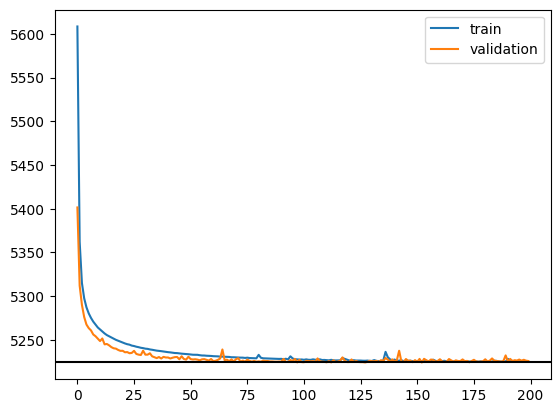

In [22]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

This output is less then optimal for sure. In a true experiment, I'd like to revisit this and see what might improve peformance. For the sake of ease and practice, I only used the CelLTypist models, but potentially providing a true SCVI Label set, or some further experimentation might improve this. It's likely that very little is being learned about the data and will likely impact the results later on with poor clustering.

In [35]:
adata.write_h5ad('temp.h5ad')

#### Clustering using SCVI Latent Representations

In [ ]:
import scvi
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
adata = sc.read("unintegrated_predicted_data.h5ad")

In [15]:
sc.pp.filter_genes(adata, min_cells = 50)

In [ ]:
model = scvi.model.SCVI.load('the_new_new_model', adata)

In [5]:
# Pulling latent representation from our SCVI model for clustering
adata.obsm['X_scVI'] = model.get_latent_representation()

In [6]:
# Sanity check on adata
adata.obsm['X_scVI'].shape

(300690, 50)

In [11]:
# Nearest Neighbors Calculation (Scanpy)
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [12]:
# Aplying ledigen algo at high res to help with annotation
sc.tl.leiden(adata, resolution = 3, key_added = 'overcluster')

In [13]:
# Running umap
sc.tl.umap(adata)

In [14]:
# Copy of X to preserve the original
adata.layers['counts'] = adata.X.copy()

In [15]:
# Per https://www.nature.com/articles/s41592-023-01814-1#Sec2, applying log1p transformation
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [18]:
# Saving
adata.write_h5ad('temp.h5ad')

In [16]:
# Grouping by OverCluster (label by base CellTypics Immune Data)
adata.obs['low_major'] = adata.obs.groupby('overcluster')['low_label'].transform(lambda x: x.mode()[0])

/tmp/ipykernel_102273/3671543583.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs['low_major'] = adata.obs.groupby('overcluster')['low_label'].transform(lambda x: x.mode()[0])


#### UMAPS Across the 3 Reference Sets

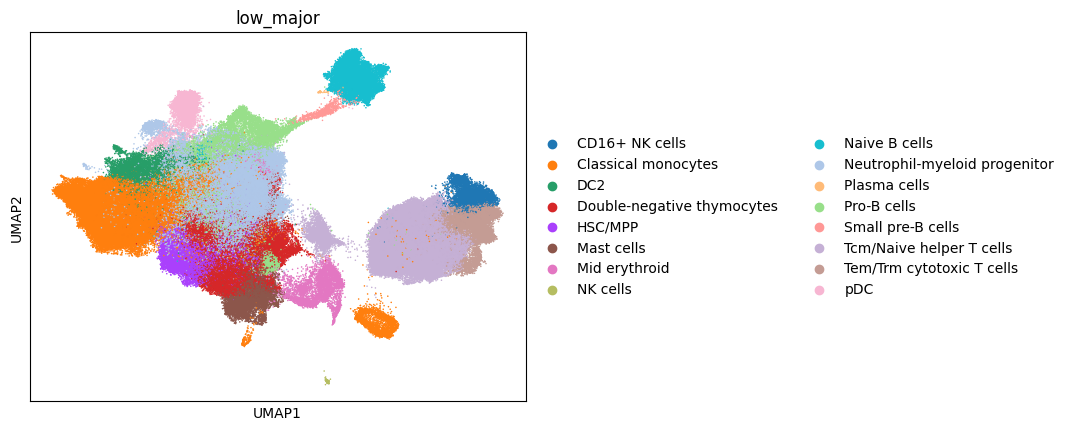

In [56]:
# Mapping by CellTypist Datset Model
sc.pl.umap(adata, color = ['low_major'], s = 5)

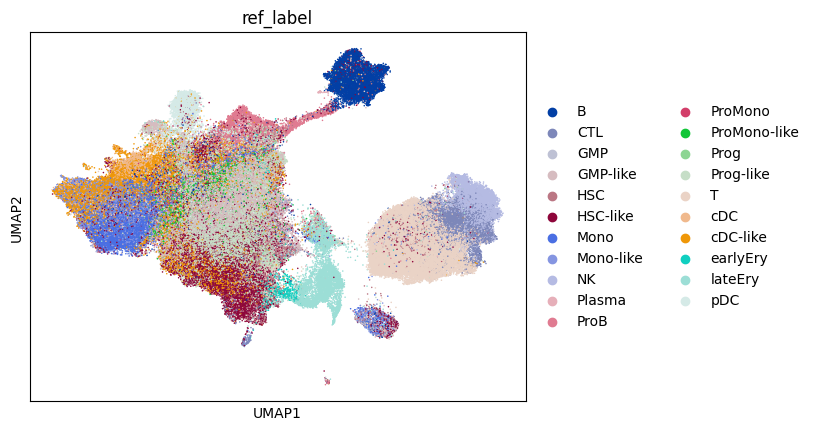

In [39]:
# Mapping by Reference Dataset 1
adata.obs['ref_major'] = adata.obs.groupby('overcluster')['ref2_label'].transform(lambda x: x.mode()[0])

sc.pl.umap(adata, color = ['ref_label'], s = 5)

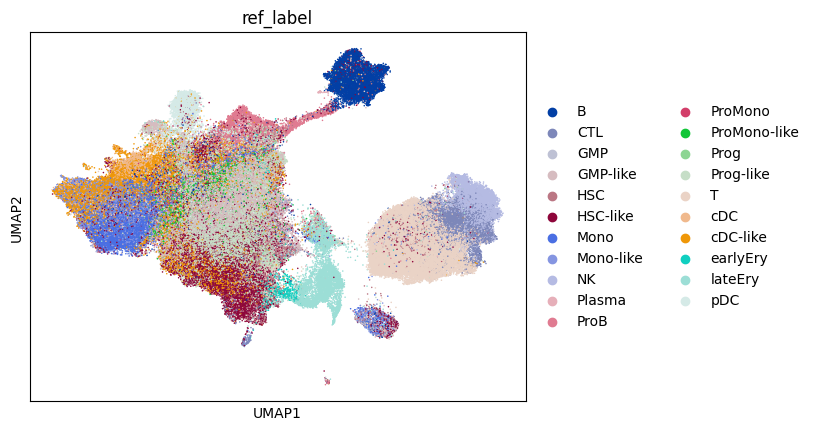

In [40]:
# Mapping by Reference Dataset 2
adata.obs['ref_major'] = adata.obs.groupby('overcluster')['ref2_label'].transform(lambda x: x.mode()[0])

sc.pl.umap(adata, color = ['ref_label'], s = 5)

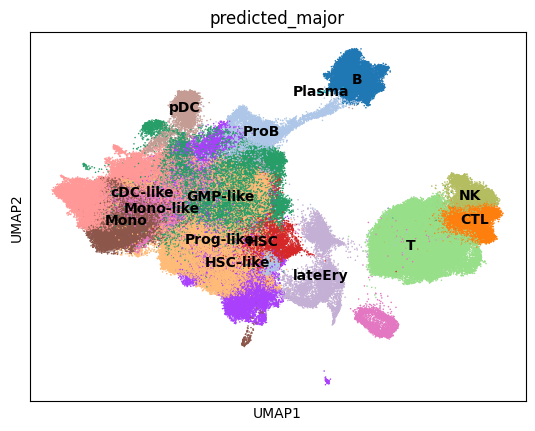

In [41]:
# Mapping with lables from Reference Set 1 
adata.obs['predicted_major'] = adata.obs.groupby('overcluster')['ref_label'].transform(lambda x: x.mode()[0])

sc.pl.umap(adata, color = ['predicted_major'], legend_loc = 'on data', s = 5)

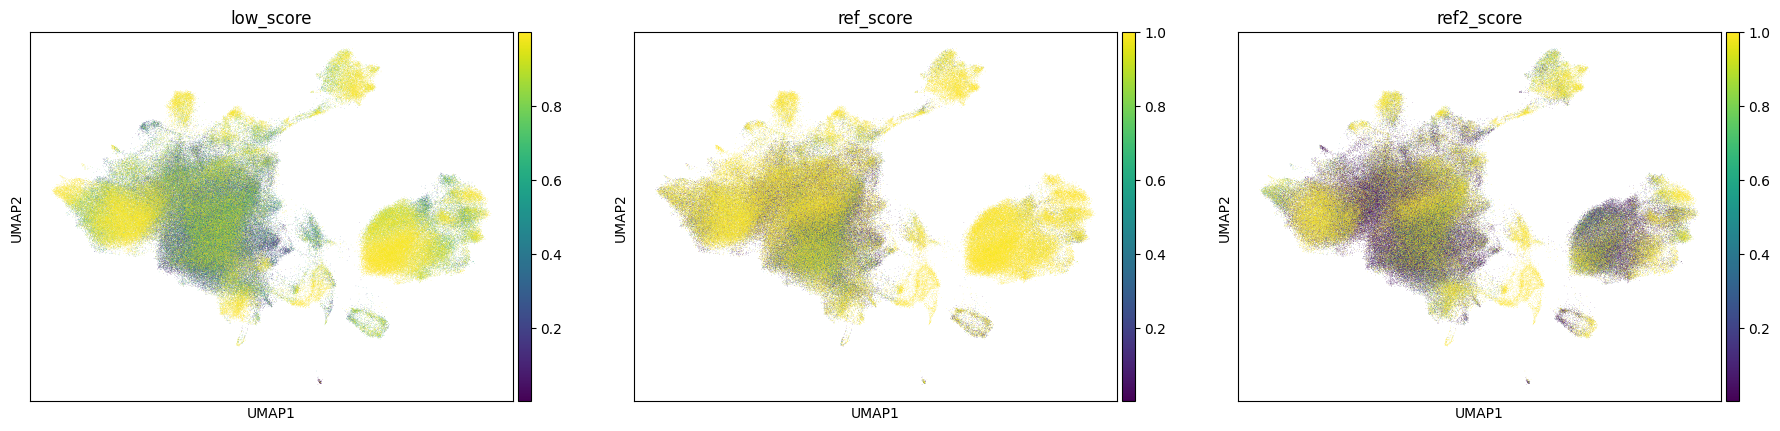

In [42]:
# Mapping scores from all 3 reference sets
sc.pl.umap(adata, color = ['low_score', 'ref_score', 'ref2_score' ])

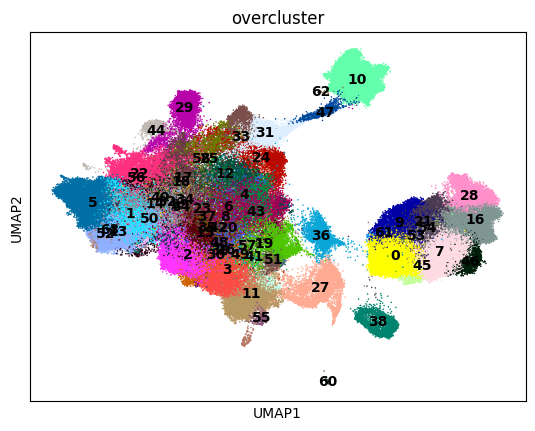

In [43]:
# Seeing net overclusters
sc.pl.umap(adata, color = ['overcluster'], legend_loc = 'on data', s = 5)

In [44]:
#np.random.seed(1)
#ri = np.random.permutation(list(range(adata.shape[0])))

#sc.pl.umap(adata[ri,:], color = ['DX'], vmin = .5, size = 2)

#### Annotating (Identifying Genetic Markers, Scoring for AML based on said markers)

In [128]:
# Genomic markers identifying, calcualting a blast score based on how these markers align with the data using scanpy
aml_marks = ['CD33', 'CD44', 'CD47', 'BST1', 'CD244', 'HAVCR2', 'CLEC12A', 'IL1RAP', 'MPO', 'AZU1', 'ELANE', 'PRTN3', 
            'CLEC11A', 'PRAME', 'NREP', 'ARMH1', 'C1QBP', 'TRH', 'CD99',]

sc.tl.score_genes(adata, aml_marks, score_name = 'AML_blast_score')

In [129]:
labels = adata.obs[['low_label', 'ref_label', 'ref2_label','overcluster']].groupby('overcluster').agg(lambda x: x.mode())
scores = adata.obs[['low_score', 'ref_score', 'ref2_score','overcluster']].groupby('overcluster').agg(lambda x: x.mean())

mapping_res = labels.merge(right = scores, left_index=True, right_index=True)

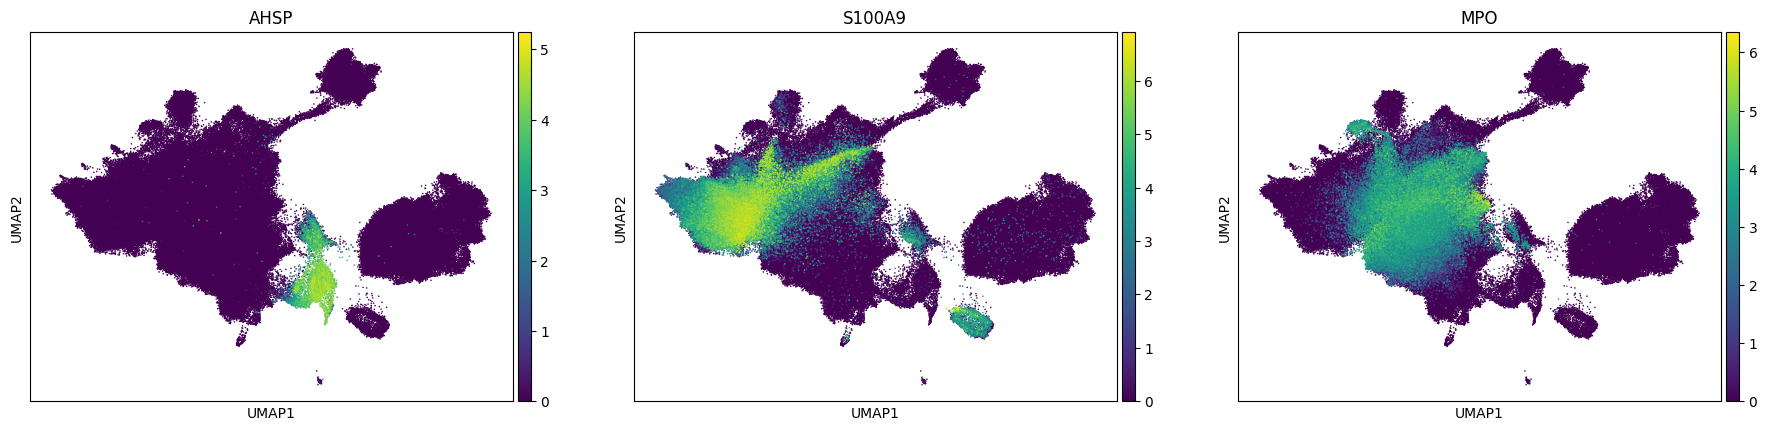

In [47]:
sc.pl.umap(adata, color = ['AHSP', 'S100A9', 'MPO'], s = 5)

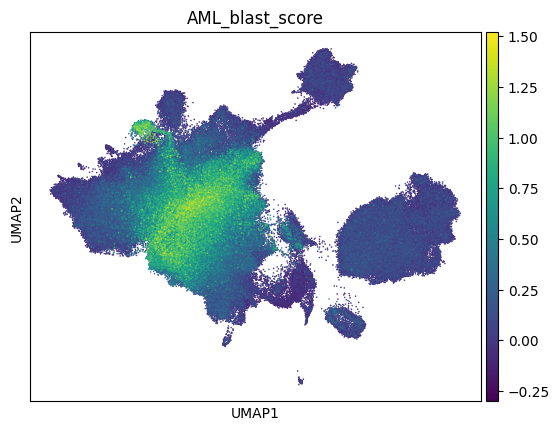

In [48]:
sc.pl.umap(adata, color = ['AML_blast_score'], s = 5)

In [130]:
# Computes median AML blast score for each cluster
aml_blast_scores = adata.obs[['overcluster', 'AML_blast_score']].groupby('overcluster').median()

<Axes: xlabel='overcluster', ylabel='AML_blast_score'>

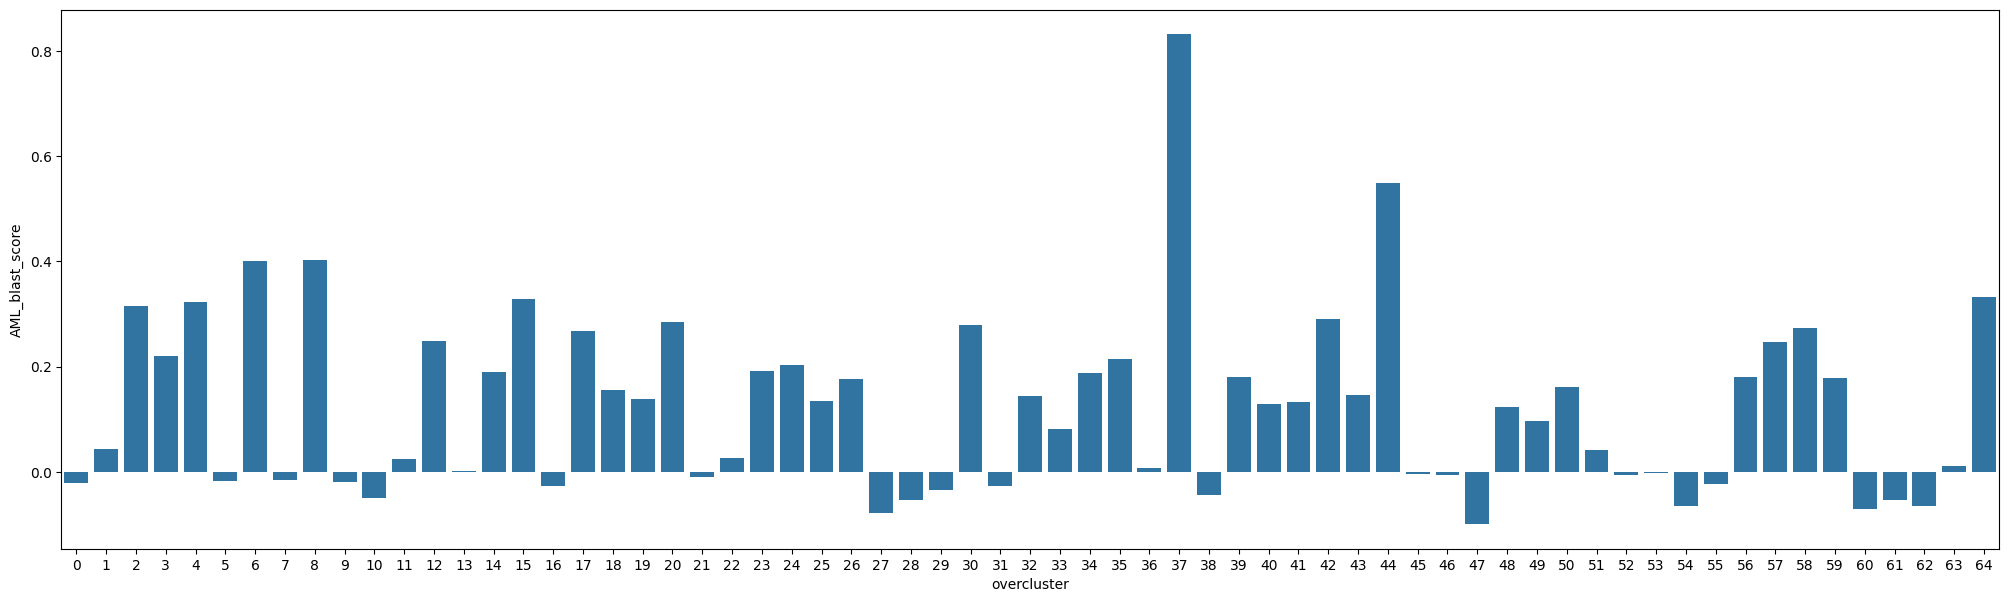

In [59]:
# Plotting AML situation
plt.figure(figsize = (25, 7))
sns.barplot(aml_blast_scores, y = 'AML_blast_score', x = aml_blast_scores.index)

In [18]:
adata = sc.read("annotated.h5ad")

#### Annotating Tools

The blocks below are just to query for genetic markers, check my predictions from the CellTypist models, and look visually to help

In [60]:
# Dataframe with final scores from reference data by overcluster
labels = adata.obs[['low_label', 'ref_label', 'ref2_label', 'overcluster']].groupby('overcluster').agg(lambda x: x.mode())
scores = adata.obs[['low_score', 'ref_score', 'ref2_score', 'overcluster']].groupby('overcluster').agg(lambda x: x.mean())

mapping_res = labels.merge(right = scores, left_index=True, right_index=True)

In [107]:
# Group and aggregate labels (using mode) and scores (using mean)
labels = adata.obs[['low_label', 'ref_label', 'ref2_label', 'overcluster']].groupby('overcluster').agg(lambda x: x.mode())
scores = adata.obs[['low_score', 'ref_score', 'ref2_score', 'overcluster']].groupby('overcluster').agg(lambda x: x.mean())

# Merge labels and scores
mapping_res = labels.merge(right=scores, left_index=True, right_index=True)

# Sort by the highest reference score (change 'ref_score' to desired score column if needed)
mapping_res = mapping_res.sort_values(by='ref_score', ascending=False)

# Display the result
mapping_res.head(20)

low_label ref_label      ref2_label  low_score  \
overcluster                                                                   
45            Tcm/Naive helper T cells         T       21_CD4.N2   0.952297   
0             Tcm/Naive helper T cells         T       21_CD4.N2   0.981388   
53            Tcm/Naive helper T cells         T       21_CD4.N2   0.981760   
54            Tcm/Naive helper T cells         T       21_CD4.N2   0.876063   
28                      CD16+ NK cells        NK           25_NK   0.816282   
9             Tcm/Naive helper T cells         T        19_CD8.N   0.890085   
7             Tcm/Naive helper T cells         T        22_CD4.M   0.861347   
29                                 pDC       pDC          09_pDC   0.897270   
10                       Naive B cells         B            17_B   0.915694   
27                       Mid erythroid   lateEry   03_Late.Eryth   0.813983   
21            Tcm/Naive helper T cells         T        19_CD8.N   0.805414   
46           Tem/Trm cytotoxic T cells         T       24_CD8.CM   0.756862   
62                        Plasma cells    Plasma            17_B   0.951011   
16           Tem/Trm cytotoxic T cells       CTL       24_CD8.CM   0.785303   
61            Tcm/Naive helper T cells         T       21_CD4.N2   0.771025   
55                          Mast cells  HSC-like  02_Early.Eryth   0.666914   
36            Tcm/Naive helper T cells   lateEry   03_Late.Eryth   0.535198   
22                                 DC2  cDC-like          10_cDC   0.596591   
58                       Naive B cells  HSC-like            17_B   0.206736   
47                   Small pre-B cells      ProB        16_Pre.B   0.827771   

             ref_score  ref2_score  
overcluster                         
45            0.991636    0.331789  
0             0.989319    0.381892  
53            0.981155    0.240790  
54            0.977422    0.326122  
28            0.970765    0.778598  
9             0.967351    0.252464  
7             0.961583    0.434785  
29            0.947447    0.694046  
10            0.946826    0.819482  
27            0.941381    0.956378  
21            0.930813    0.311743  
46            0.921524    0.720716  
62            0.913220    0.072298  
16            0.894991    0.532426  
61            0.888276    0.329838  
55            0.862567    0.232327  
36            0.850554    0.894281  
22            0.849157    0.260137  
58            0.840144    0.188173  
47            0.834717    0.846377

In [428]:
# Export to CSV
mapping_res.to_csv('mapping_results.csv')

In [ ]:
# Quick way to see differential expression for each cluster
sc.tl.rank_genes_groups(adata, groupby = 'overcluster')
marks = sc.get.rank_genes_groups_df(adata, group = None)

In [74]:
marks

group   names      scores  logfoldchanges  pvals  pvals_adj
0           0   RPS27  362.386414        1.717705    0.0        0.0
1           0   RPL30  277.618744        1.201699    0.0        0.0
2           0  RPS27A  251.078735        1.056969    0.0        0.0
3           0   RPL13  243.940460        0.975945    0.0        0.0
4           0   RPS12  242.943634        1.040514    0.0        0.0
...       ...     ...         ...             ...    ...        ...
1375590    64  DNAJB1 -272.051117      -27.830420    0.0        0.0
1375591    64  CREBZF -285.771637      -27.717255    0.0        0.0
1375592    64  UBE2G2 -287.647797      -27.578079    0.0        0.0
1375593    64   POLE3 -317.586487      -27.937460    0.0        0.0
1375594    64    XIST -322.715240      -28.972820    0.0        0.0

[1375595 rows x 6 columns]

In [183]:
mapping_res[38:40]

low_label  ref_label      ref2_label  low_score  \
overcluster                                                              
38           Classical monocytes  Mono-like  12_CD14.Mono.2   0.705724   
39                       HSC/MPP  Prog-like     05_CMP.LMPP   0.554498   

             ref_score  ref2_score  
overcluster                         
38            0.633577    0.520633  
39            0.659109    0.280537

In [ ]:
marks[(marks.names == 'CD14') ].sort_values('logfoldchanges', ascending = False).head(5)

In [488]:
marks[(marks.names == 'CX3CR1') ].sort_values('logfoldchanges', ascending = False).head(20)

group   names     scores  logfoldchanges          pvals      pvals_adj
22278       1  CX3CR1  34.142086        3.067922  7.746538e-246  6.718852e-245
847489     40  CX3CR1   9.554065        2.486460   3.940120e-21   1.816624e-20
593376     28  CX3CR1  10.609281        2.223875   5.567813e-26   1.812794e-25
107586      5  CX3CR1  18.140339        2.088686   1.331222e-72   4.907273e-72
257020     12  CX3CR1  13.556162        1.603379   1.941809e-41   8.263523e-41
297749     14  CX3CR1  11.447783        1.580441   4.066652e-30   1.835414e-29
723080     34  CX3CR1   7.593511        1.324785   4.156934e-14   1.386059e-13
1253588    59  CX3CR1   1.119945        0.729471   2.643724e-01   4.660812e-01
469122     22  CX3CR1   4.718609        0.638759   2.426779e-06   5.704535e-06
340996     16  CX3CR1   3.578248        0.607221   3.479476e-04   5.101929e-04
366595     17  CX3CR1   4.603037        0.548145   4.228637e-06   9.053175e-06
131611      6  CX3CR1   3.206820        0.341371   1.345731e-03   2.137314e-03
501193     23  CX3CR1  -1.246191       -0.188758   2.127510e-01   2.691886e-01
983360     46  CX3CR1  -1.161950       -0.393794   2.454766e-01   3.118073e-01
395015     18  CX3CR1  -3.930446       -0.501638   8.551040e-05   1.598354e-04
757332     35  CX3CR1  -2.533943       -0.538099   1.133288e-02   2.327618e-02
1109181    52  CX3CR1  -1.310594       -0.646778   1.904993e-01   2.494917e-01
1068847    50  CX3CR1  -1.929289       -0.730883   5.407146e-02   8.308388e-02
103366      4  CX3CR1 -10.555135       -0.928931   5.835632e-26   1.639228e-25
527197     24  CX3CR1  -7.611642       -1.056321   3.205261e-14   1.025131e-13

In [80]:
marks[(marks.names == 'CD34') ].sort_values('logfoldchanges', ascending = False).head(20)

group names     scores  logfoldchanges          pvals      pvals_adj
1227470    58  CD34  22.081598        3.664212   2.217211e-53   1.064251e-52
1206368    57  CD34  18.424810        2.961227   1.325091e-48   9.686665e-48
825378     39  CD34  41.595623        2.552911  6.914199e-274  4.926774e-272
42380       2  CD34  83.421700        2.244982   0.000000e+00   0.000000e+00
169400      8  CD34  81.488327        2.142889   0.000000e+00   0.000000e+00
634967     30  CD34  40.053799        1.894681  3.199185e-290  1.870286e-288
550288     26  CD34  41.328514        1.847499   0.000000e+00   0.000000e+00
85003       4  CD34  72.472839        1.803670   0.000000e+00   0.000000e+00
486947     23  CD34  45.143974        1.792357   0.000000e+00   0.000000e+00
1355231    64  CD34   2.297786        1.723819   6.128374e-02   9.670056e-02
317589     15  CD34  46.676167        1.648776   0.000000e+00   0.000000e+00
63630       3  CD34  53.218864        1.593113   0.000000e+00   0.000000e+00
529160     25  CD34  26.248884        1.341725  9.536886e-142  3.844364e-140
698667     33  CD34  18.131489        1.160925   6.878804e-70   7.416002e-69
509133     24  CD34  22.952141        1.078774  1.370355e-110  1.932100e-109
423578     20  CD34  24.866232        0.971596  1.011910e-130  2.107780e-129
360830     17  CD34  24.713869        0.946150  6.675824e-130  9.797536e-129
1017390    48  CD34   7.620221        0.934406   6.722106e-14   2.468505e-13
1039069    49  CD34   3.635670        0.464559   2.958976e-04   6.118899e-04
891204     42  CD34   3.937265        0.319698   8.592132e-05   2.387857e-04

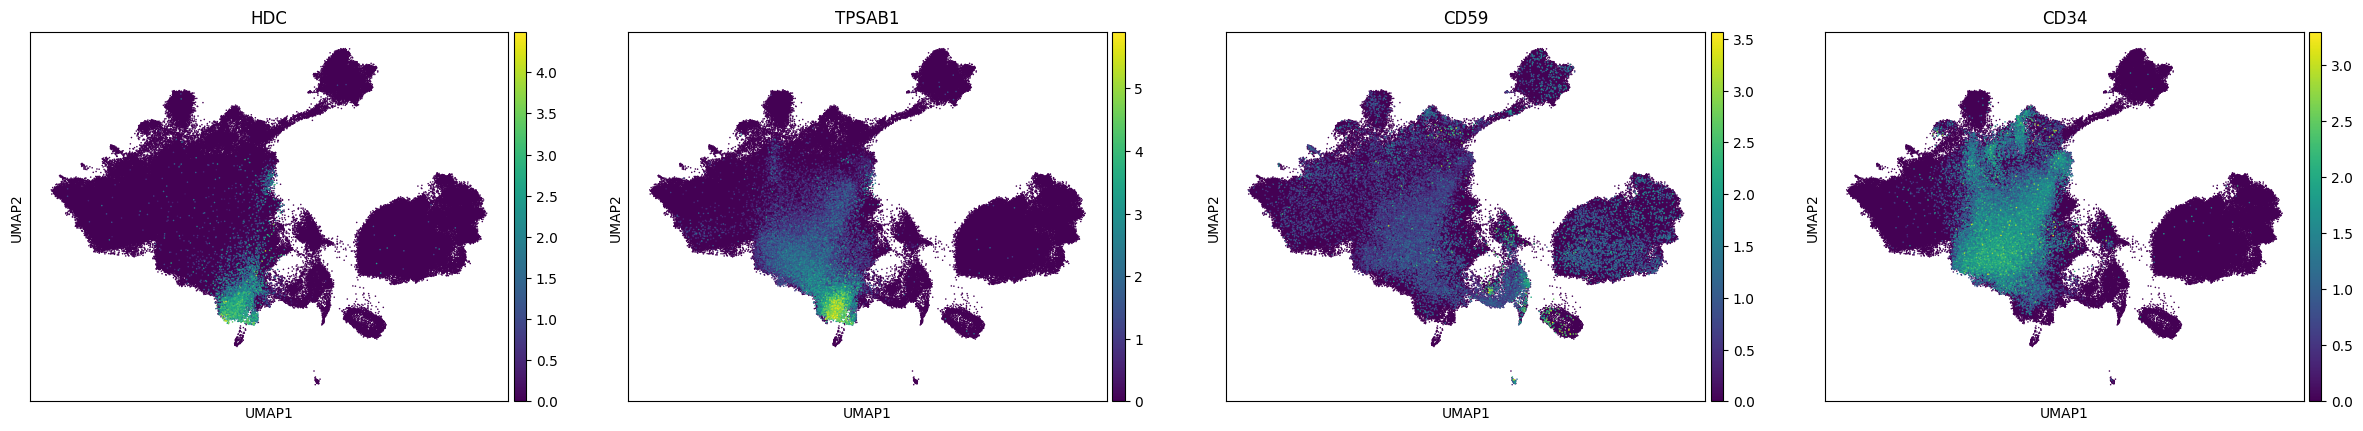

In [81]:
sc.pl.umap(adata, color = ['HDC', 'TPSAB1', 'CD59', 'CD34'], legend_loc = 'on data', s = 5)

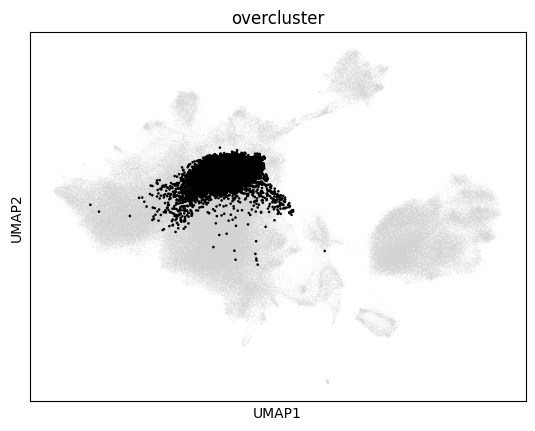

In [492]:
ax = sc.pl.umap(adata, palette = 'lightgrey', show = False)
sc.pl.umap(adata[adata.obs.overcluster == '12'], color = 'overcluster', ax = ax, legend_loc = None, palette = 'k')

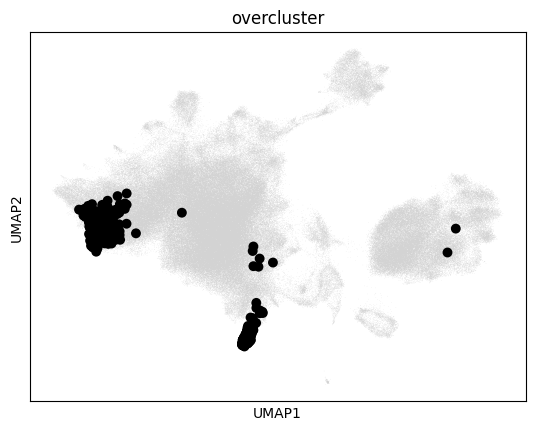

In [556]:
ax = sc.pl.umap(adata, palette = 'lightgrey', show = False)
sc.pl.umap(adata[adata.obs.overcluster == '52'], color = 'overcluster', ax = ax, legend_loc = None, palette = 'k')

In [508]:
aml_blast_scores[aml_blast_scores.index == '2']

AML_blast_score
overcluster                 
2                   0.315534

### Final Annotations

In [4]:
# Tracking the annotations
over2cell = {
    "0": "Th", "1": "Mono", "2": "AML-Blast", "3": "AML-Blast", "4": "AML-Blast", "5": "Mono", "6": "AML-Blast", "7": "Th", "8": "AML-Blast", "9": "Tc",
    "10": "B", "11": "Mast", "12": "AML-Blast", "13": "Mono", "14": "AML-Blast", "15": "AML-Blast", "16": "Tc", "17": "AML-Blast", "18": "AML-Blast", "19": "AML-Blast",
    "20": "AML-Blast", "21": "Tc", "22": "DC", "23": "AML-Blast", "24": "AML-Blast", "25": "AML-Blast", "26": "AML-Blast", "27": "Erythroid", "28": "NK", "29": "pDC",
    "30": "HSC-like", "31": "Pro-B", "32": "AML-Blast", "33": "AML-Blast", "34": "AML-Blast", "35": "AML-Blast", "36": "Late-Erythroid", "37": "AML-Blast", "38": "Neutrophil", "39": "AML-Blast",
    "40": "AML-Blast", "41": "AML-Blast", "42": "AML-Blast", "43": "AML-Blast", "44": "AML-Blast", "45": "Th", "46": "Tc", "47": "Pre-B", "48": "AML-Blast", "49": "AML-Blast",
    "50": "AML-Blast", "51": "AML-Blast", "52": "Mono", "53": "Th", "54": "Th", "55": "HSC-like", "56": "AML-Blast", "57": "AML-Blast", "58": "AML-Blast", "59": "AML-Blast",
    "60": "Unk1", "61": "Th", "62": "Plasma", "63": "Mono", "64": "AML-Blast"
}

In [568]:
adata.obs['Cell Type'] = adata.obs.overcluster.map(over2cell)

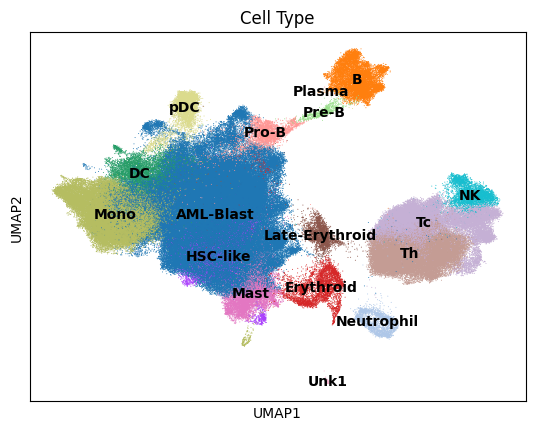

In [569]:
sc.pl.umap(adata, color = ['Cell Type'], s = 2, legend_loc = 'on data')

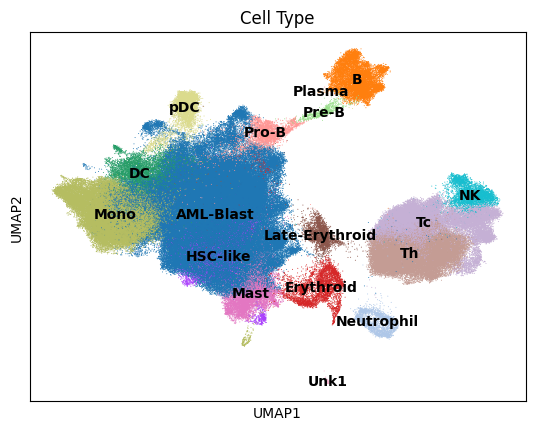

In [571]:
# Create UMAP plot and save as high-resolution image
sc.pl.umap(adata, color=['Cell Type'], s=2, legend_loc='on data', save='umap_high_res.png')

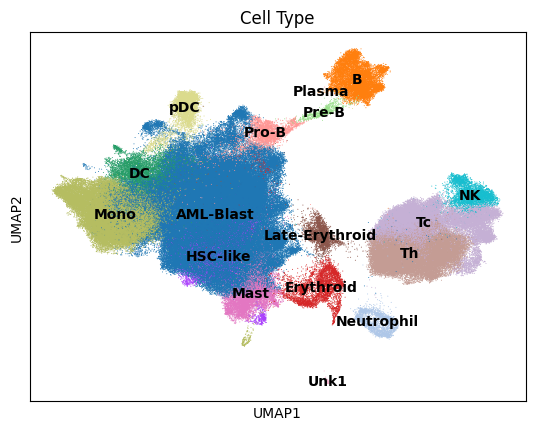

In [571]:
# Create UMAP plot and save as high-resolution image
sc.pl.umap(adata, color=['Cell Type'], s=2, legend_loc='on data', save='umap_high_res.png')

In [17]:
adata.write_h5ad('annotated.h5ad')

In [18]:
adata.obs.head()

Patient  DX    Sample  n_genes  n_genes_by_counts  \
TCAAGACCATCGCTGG-1-AML16_DX   AML16  DX  AML16_DX     6710               6710   
TCTACATGTCCGGCAT-1-AML16_DX   AML16  DX  AML16_DX     6996               6996   
TCGTCCATCGAACCTA-1-AML16_DX   AML16  DX  AML16_DX     6587               6587   
TACCGGGGTTTACGAC-1-AML16_DX   AML16  DX  AML16_DX     6424               6424   
GATGACTTCTCGGTAA-1-AML16_DX   AML16  DX  AML16_DX     6337               6337   

                             log1p_n_genes_by_counts  total_counts  \
TCAAGACCATCGCTGG-1-AML16_DX                 8.811503       54567.0   
TCTACATGTCCGGCAT-1-AML16_DX                 8.853237       53716.0   
TCGTCCATCGAACCTA-1-AML16_DX                 8.793005       50418.0   
TACCGGGGTTTACGAC-1-AML16_DX                 8.767952       49252.0   
GATGACTTCTCGGTAA-1-AML16_DX                 8.754319       47161.0   

                             log1p_total_counts  pct_counts_in_top_20_genes  \
TCAAGACCATCGCTGG-1-AML16_DX           10.907203                   17.327322   
TCTACATGTCCGGCAT-1-AML16_DX           10.891485                   20.304937   
TCGTCCATCGAACCTA-1-AML16_DX           10.828123                   18.170098   
TACCGGGGTTTACGAC-1-AML16_DX           10.804726                   19.239828   
GATGACTTCTCGGTAA-1-AML16_DX           10.761344                   18.205721   

                             pct_counts_mt  ...  \
TCAAGACCATCGCTGG-1-AML16_DX       6.756831  ...   
TCTACATGTCCGGCAT-1-AML16_DX       7.327426  ...   
TCGTCCATCGAACCTA-1-AML16_DX       8.338292  ...   
TACCGGGGTTTACGAC-1-AML16_DX       7.932673  ...   
GATGACTTCTCGGTAA-1-AML16_DX       6.312419  ...   

                                                 low_label  low_score  \
TCAAGACCATCGCTGG-1-AML16_DX  Neutrophil-myeloid progenitor   0.787524   
TCTACATGTCCGGCAT-1-AML16_DX            Classical monocytes   0.157189   
TCGTCCATCGAACCTA-1-AML16_DX  Neutrophil-myeloid progenitor   0.944807   
TACCGGGGTTTACGAC-1-AML16_DX                  Mid erythroid   0.999895   
GATGACTTCTCGGTAA-1-AML16_DX  Neutrophil-myeloid progenitor   0.318441   

                             ref_label  ref_score     ref2_label  ref2_score  \
TCAAGACCATCGCTGG-1-AML16_DX   GMP-like   0.999999    08_GMP.Neut    0.999397   
TCTACATGTCCGGCAT-1-AML16_DX    lateEry   0.000144  03_Late.Eryth    0.993653   
TCGTCCATCGAACCTA-1-AML16_DX   GMP-like   1.000000    08_GMP.Neut    0.999847   
TACCGGGGTTTACGAC-1-AML16_DX    lateEry   1.000000  03_Late.Eryth    1.000000   
GATGACTTCTCGGTAA-1-AML16_DX   GMP-like   0.999998    08_GMP.Neut    0.978792   

                            _scvi_batch  _scvi_labels overcluster  \
TCAAGACCATCGCTGG-1-AML16_DX           0             0          24   
TCTACATGTCCGGCAT-1-AML16_DX           0             0          27   
TCGTCCATCGAACCTA-1-AML16_DX           0             0           4   
TACCGGGGTTTACGAC-1-AML16_DX           0             0          27   
GATGACTTCTCGGTAA-1-AML16_DX           0             0          24   

                                                 low_major  
TCAAGACCATCGCTGG-1-AML16_DX  Neutrophil-myeloid progenitor  
TCTACATGTCCGGCAT-1-AML16_DX                  Mid erythroid  
TCGTCCATCGAACCTA-1-AML16_DX  Neutrophil-myeloid progenitor  
TACCGGGGTTTACGAC-1-AML16_DX                  Mid erythroid  
GATGACTTCTCGGTAA-1-AML16_DX  Neutrophil-myeloid progenitor  

[5 rows x 24 columns]

In [3]:
adata = sc.read("annotated.h5ad")

In [5]:
adata.obs["Cell Type"] = adata.obs["overcluster"].map(over2cell)

In [6]:
adata.write_h5ad('annotated.h5ad')